In [24]:
import numpy as np
import torch

Softthresholding function

In [25]:
def softthreshold(x, shrinkage):   
    # compare each pixels in x with shrinkage value
    x_thx = 0
    x_abs = np.abs(x)

    if x_abs <= shrinkage:
        x_thx = 0
    else:
        x_thx = ((x_abs - shrinkage)/x_abs)*x    

    return x_thx

Test the soft thresholding function

In [26]:
x_in = np.arange(-4, 4.1, 0.1)
print(x_in)

# apply soft thresholding
for x in x_in:
    x_out = softthreshold(x, 1)
    



[-4.00000000e+00 -3.90000000e+00 -3.80000000e+00 -3.70000000e+00
 -3.60000000e+00 -3.50000000e+00 -3.40000000e+00 -3.30000000e+00
 -3.20000000e+00 -3.10000000e+00 -3.00000000e+00 -2.90000000e+00
 -2.80000000e+00 -2.70000000e+00 -2.60000000e+00 -2.50000000e+00
 -2.40000000e+00 -2.30000000e+00 -2.20000000e+00 -2.10000000e+00
 -2.00000000e+00 -1.90000000e+00 -1.80000000e+00 -1.70000000e+00
 -1.60000000e+00 -1.50000000e+00 -1.40000000e+00 -1.30000000e+00
 -1.20000000e+00 -1.10000000e+00 -1.00000000e+00 -9.00000000e-01
 -8.00000000e-01 -7.00000000e-01 -6.00000000e-01 -5.00000000e-01
 -4.00000000e-01 -3.00000000e-01 -2.00000000e-01 -1.00000000e-01
  3.55271368e-15  1.00000000e-01  2.00000000e-01  3.00000000e-01
  4.00000000e-01  5.00000000e-01  6.00000000e-01  7.00000000e-01
  8.00000000e-01  9.00000000e-01  1.00000000e+00  1.10000000e+00
  1.20000000e+00  1.30000000e+00  1.40000000e+00  1.50000000e+00
  1.60000000e+00  1.70000000e+00  1.80000000e+00  1.90000000e+00
  2.00000000e+00  2.10000

In [1]:
import torch
from Fast_MRI_dataloader import create_dataloaders
from tqdm import tqdm 
import matplotlib.pyplot as plt
from torch.fft import fft2, fftshift, ifft2

def get_k_space(input) :
    # get the k-space
    k_space = fftshift(fft2(input))
    return k_space



In [20]:
  # define parameters
data_loc = 'Fast_MRI_Knee/' #change the datalocation to something that works for you
batch_size = 2

train_loader, test_loader = create_dataloaders(data_loc, batch_size)

# go over the dataset
for i,(kspace, M, gt) in enumerate(tqdm(test_loader)):
    continue

100%|██████████| 123/123 [00:04<00:00, 27.61it/s]


Exercise 3a

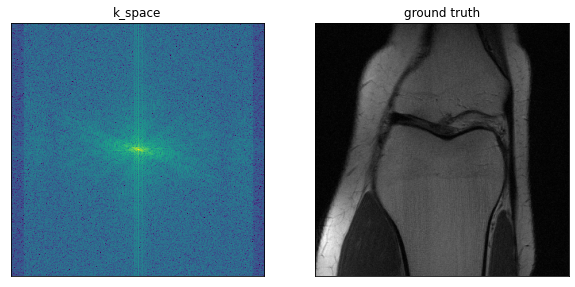

In [21]:
k_space = get_k_space(gt)
        
kspace_plot_friendly = torch.log(torch.abs(k_space[0,:,:])+1e-20)

plt.figure(figsize = (10,10))

plt.subplot(1,2,1)
plt.imshow(kspace_plot_friendly,vmin=-2,interpolation='nearest')
plt.xticks([])
plt.yticks([])
plt.title('k_space')

plt.subplot(1,2,2)
plt.imshow(gt[0,:,:],cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title('ground truth')

#plt.savefig("assignment_4/figures/3a.png",dpi=300,bbox_inches='tight')
plt.show()

Exercise 3b

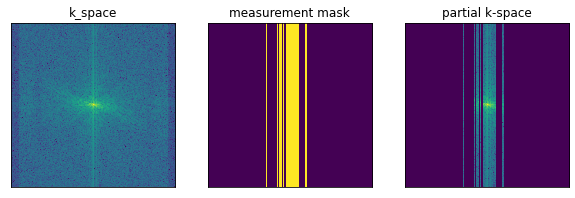

In [22]:

par_k_space = torch.mul(k_space, M)

kspace_plot_friendly = torch.log(torch.abs(k_space[0,:,:])+1e-20)
par_k_space_friendly = torch.log(torch.abs(par_k_space[0,:,:])+1e-20)

plt.figure(figsize = (10,10))

plt.subplot(1,3,1)
plt.imshow(kspace_plot_friendly,vmin=-2,interpolation='nearest')
plt.xticks([])
plt.yticks([])
plt.title('k_space')

plt.subplot(1,3,2)
plt.imshow(M[0,:,:],interpolation='nearest')
plt.xticks([])
plt.yticks([])
plt.title('measurement mask')

plt.subplot(1,3,3)
plt.imshow(par_k_space_friendly,vmin=-2,interpolation='nearest')
plt.xticks([])
plt.yticks([])
plt.title('partial k-space')

#plt.savefig("assignment_4/figures/3a.png",dpi=300,bbox_inches='tight')
plt.show()

exercise 3c

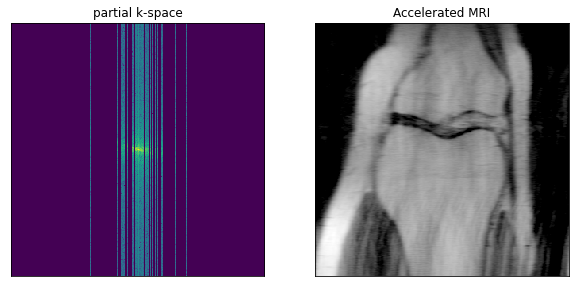

In [25]:
fastmri = torch.fft.ifft2(par_k_space)
fastmri_plot_friendly = torch.log(torch.abs(fastmri[0,:,:])+1e-20)

plt.figure(figsize = (10,10))

plt.subplot(1,2,1)
plt.imshow(par_k_space_friendly,vmin=-2,interpolation='nearest')
plt.xticks([])
plt.yticks([])
plt.title('partial k-space')

plt.subplot(1,2,2)
plt.imshow(fastmri_plot_friendly,vmin=-2,interpolation='nearest',cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title('Accelerated MRI')

#plt.savefig("assignment_4/figures/3a.png",dpi=300,bbox_inches='tight')
plt.show()

exercise 3d

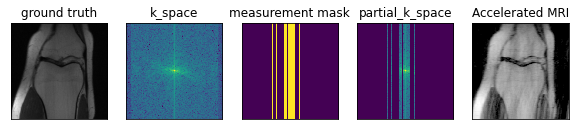

In [27]:
plt.figure(figsize = (10,10))

plt.subplot(1,5,1)
plt.imshow(gt[0,:,:],cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title('ground truth')

plt.subplot(1,5,2)
plt.imshow(kspace_plot_friendly,vmin=-2,interpolation='nearest')
plt.xticks([])
plt.yticks([])
plt.title('k_space')

plt.subplot(1,5,3)
plt.imshow(M[0,:,:],interpolation='nearest')
plt.xticks([])
plt.yticks([])
plt.title('measurement mask')

plt.subplot(1,5,4)
plt.imshow(par_k_space_friendly,vmin=-2,interpolation='nearest')
plt.xticks([])
plt.yticks([])
plt.title('partial_k_space')

plt.subplot(1,5,5)
plt.imshow(fastmri_plot_friendly,vmin=-2,interpolation='nearest',cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title('Accelerated MRI')


#plt.savefig("assignment_4/figures/3a.png",dpi=300,bbox_inches='tight')
plt.show()